# Lecture 2: How to use technical analysis to build a trading algo 

### Using built-in technical indicators in Quantopian

In [52]:
import datetime 

from quantopian.pipeline import CustomFactor, Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline, symbols
from quantopian.pipeline.data import EquityPricing

from quantopian.pipeline.factors import  Returns, FastStochasticOscillator, RSI, SimpleMovingAverage
from quantopian.pipeline.filters import  StaticAssets, QTradableStocksUS

In [53]:


# Get the latest daily close price for all equities.
yesterday_close = EquityPricing.close.latest

# Combine technical indicators 
RSI_normalised = RSI(window_length=15).zscore()
combined_factor = SimpleMovingAverage([RSI_normalised],window_length=10)


    
    
# Add the factor to the pipeline.
pipe = Pipeline({
                'close': yesterday_close,
                'Stochastic7': FastStochasticOscillator(window_length=7),
                'RSI15': RSI(window_length=15), 
                'combined_factor': combined_factor,
        },
        domain = US_EQUITIES,
        screen =  QTradableStocksUS(),
)


enddate = datetime.datetime.now() + datetime.timedelta(days=-1)
startdate = datetime.datetime.now() + datetime.timedelta(days=-6)

df = run_pipeline(pipe, startdate, enddate)
# Run the pipeline over a year and print the result.
df.tail(5)



RSI15  Stochastic7  \
2020-10-15 00:00:00+00:00 Equity(53722 [SITM])  73.777933    73.893406   
                          Equity(53749 [GRWG])  66.260163    49.604222   
                          Equity(53770 [XP])    52.445870    68.146214   
                          Equity(53775 [BILL])  94.060074    94.992009   
                          Equity(53785 [SPT])   92.350624    92.018349   

                                                 close  combined_factor  
2020-10-15 00:00:00+00:00 Equity(53722 [SITM])   90.18         1.372816  
                          Equity(53749 [GRWG])   17.43         0.234257  
                          Equity(53770 [XP])     43.02        -0.677481  
                          Equity(53775 [BILL])  119.83         2.113659  
                          Equity(53785 [SPT])    49.13         1.815681

Write you own factor: Money Flow Index

In [54]:
class MoneyFlowIndex(CustomFactor):
    """
    Money Flow Index 
    """
    inputs = [EquityPricing.high, EquityPricing.low, EquityPricing.close, EquityPricing.volume]
    window_length = 15

    def compute(self, today, assets, out, highs, lows, closes, volume):
        import numpy as np
        
        typical_price = (highs+lows+closes)/3
        typical_price_diff = np.diff(typical_price,axis=0)
        money_flow = closes[1:,]*volume[1:,]
        positive_money_ratio = np.sum(np.where(typical_price_diff>0,money_flow,0),axis=0)
        negative_money_ratio = np.sum(np.where(typical_price_diff<0,money_flow,0),axis=0)
        MFR = positive_money_ratio/negative_money_ratio
        out[:] = 100 - 100/(1+MFR)

In [55]:

def make_pipeline():

    # Get the latest daily close price for all equities.
    yesterday_close = EquityPricing.close.latest

    # Combine technical indicators 
    RSI_normalised = RSI(window_length=15).zscore()
    MFI_normalised =  MoneyFlowIndex(window_length=15).zscore()
    combined_factor = -(RSI_normalised + MFI_normalised)/2


    # Filter to select securities to short.
    shorts = combined_factor.top(75,mask=QTradableStocksUS())

    # Filter to select securities to long.
    longs = combined_factor.bottom(75,mask=QTradableStocksUS())

    # Filter for all securities that we want to trade.
    securities_to_trade = (shorts | longs)

    # Add the factor to the pipeline.
    pipe = Pipeline({
                    'close': yesterday_close,
                    'RSI': SimpleMovingAverage([RSI(window_length=15)],window_length=10),
                    'MFI': MoneyFlowIndex(),
                    'combined_factor': combined_factor,
                    'longs': longs,
                    'shorts': shorts,
            },
            domain = US_EQUITIES,
            screen =  (QTradableStocksUS() & securities_to_trade) ,
    )
    
    return pipe 


enddate = datetime.datetime.now() + datetime.timedelta(days=-1)
startdate = datetime.datetime.now() + datetime.timedelta(days=-90)

factor_data = run_pipeline(make_pipeline(), startdate, enddate)


### Use alphalens to analyse our technical analysis factor.

Alphalens provides a quick way to analyse the predictive power of a given factor for future returns. Running a backtest could be time consuming therefore it is better to alphalens in the research stage to refine ideas before going through a complete backtest. 

In [56]:
import pandas as pd

In [57]:
pricing_data = get_pricing(
  symbols= factor_data.index.levels[1], # Finds all assets that appear at least once in "factor_data"  
  start_date= startdate,
  end_date= enddate + pd.Timedelta(days=90), # must be after run_pipeline()'s end date. Explained more in lesson 4
  fields='open_price' # Generally, you should use open pricing. Explained more in lesson 4
)


In [58]:
from alphalens.utils import get_clean_factor_and_forward_returns

merged_data = get_clean_factor_and_forward_returns(
  factor=factor_data['combined_factor'], 
  prices=pricing_data
)


Dropped 17.7% entries from factor data: 17.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.198668,-1.491068,-1.892421,0.240701,1560,20.061728
2,-1.931723,-1.314153,-1.565618,0.125243,1558,20.036008
3,-1.666939,1.744782,0.052725,1.481122,1540,19.804527
4,1.394364,1.964342,1.654217,0.113224,1558,20.036008
5,1.559633,2.891332,1.982635,0.212228,1560,20.061728


Returns Analysis


,1D,5D,10D
Ann. alpha,0.094,0.140,0.065
beta,-0.041,-0.060,-0.023
Mean Period Wise Return Top Quantile (bps),14.358,4.370,4.188
Mean Period Wise Return Bottom Quantile (bps),-7.777,-3.768,-3.584
Mean Period Wise Spread (bps),22.135,8.211,7.843


<Figure size 1008x576 with 0 Axes>

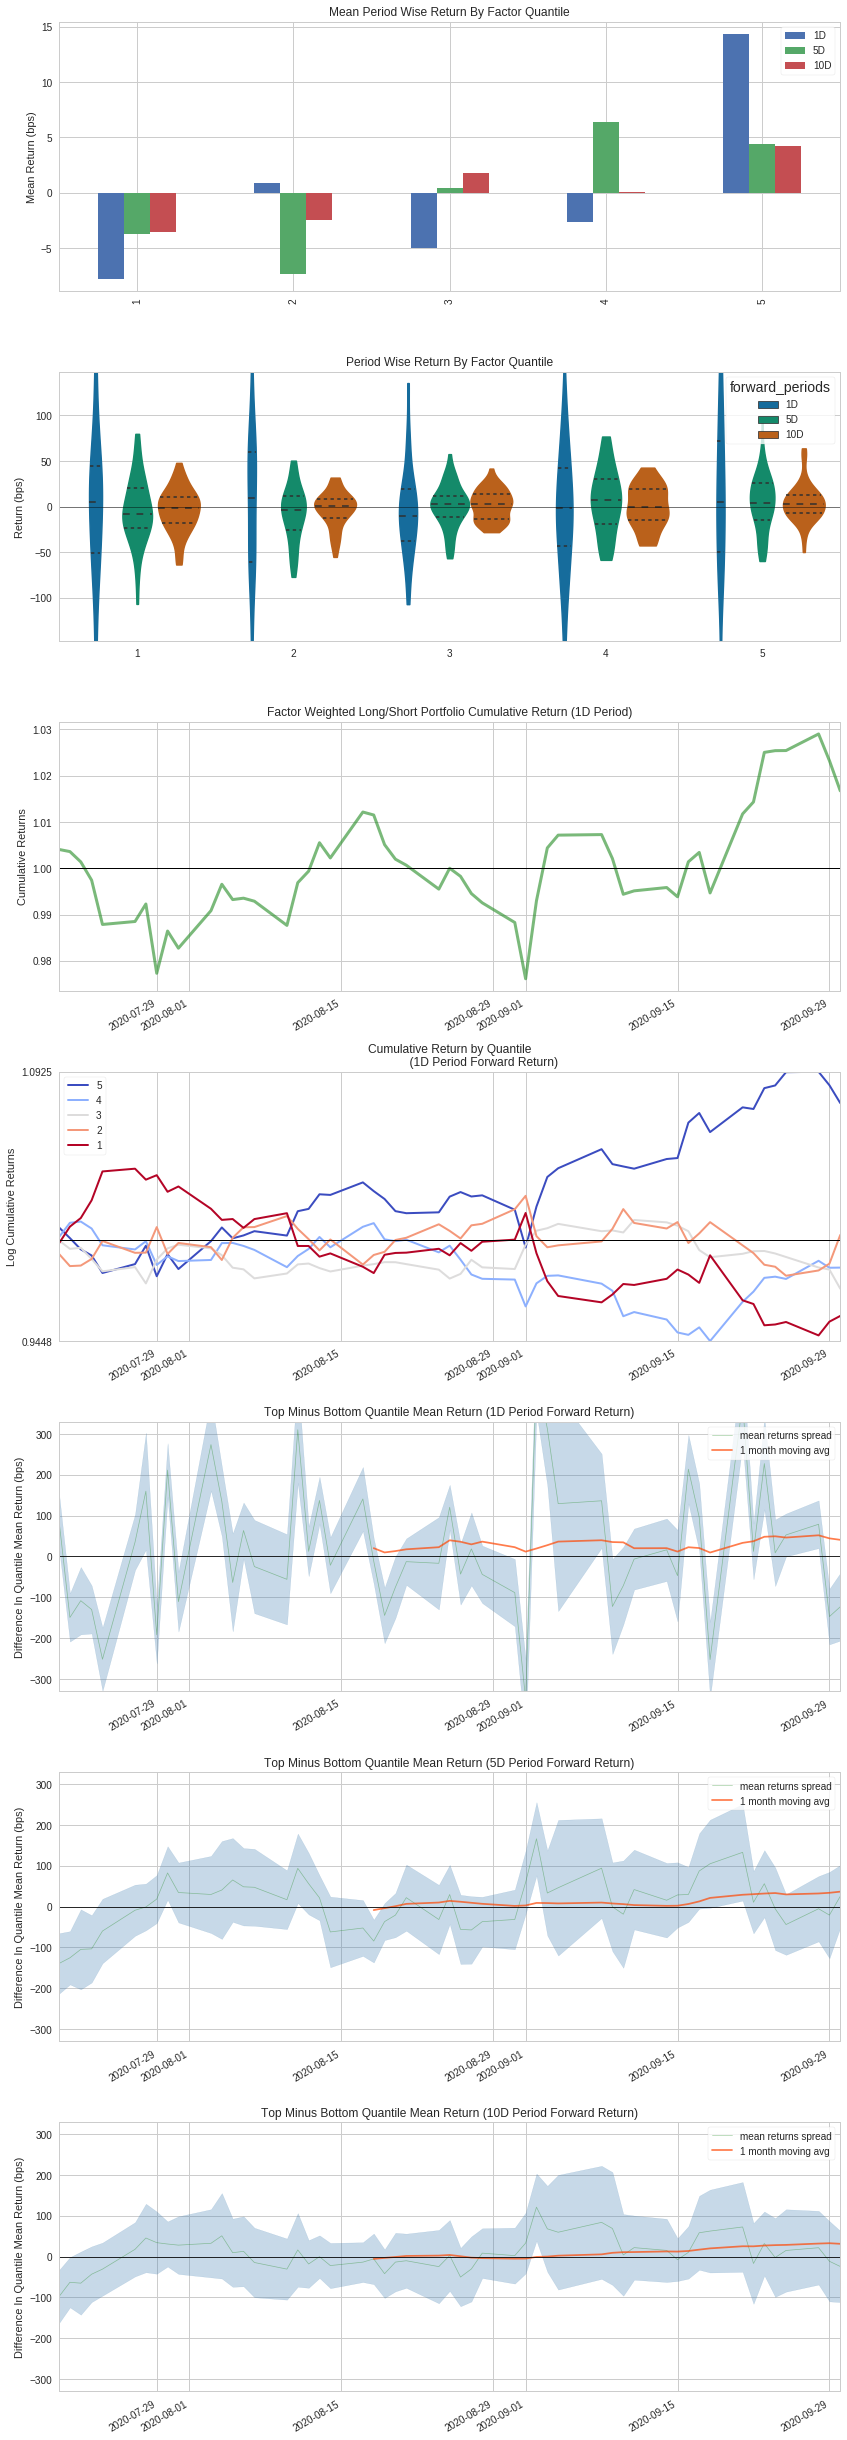

Information Analysis


,1D,5D,10D
IC Mean,0.001,0.031,0.046
IC Std.,0.205,0.187,0.159
Risk-Adjusted IC,0.004,0.165,0.288
t-stat(IC),0.031,1.188,2.075
p-value(IC),0.975,0.240,0.043
IC Skew,0.284,-0.410,-0.434
IC Kurtosis,-0.693,-0.469,0.556


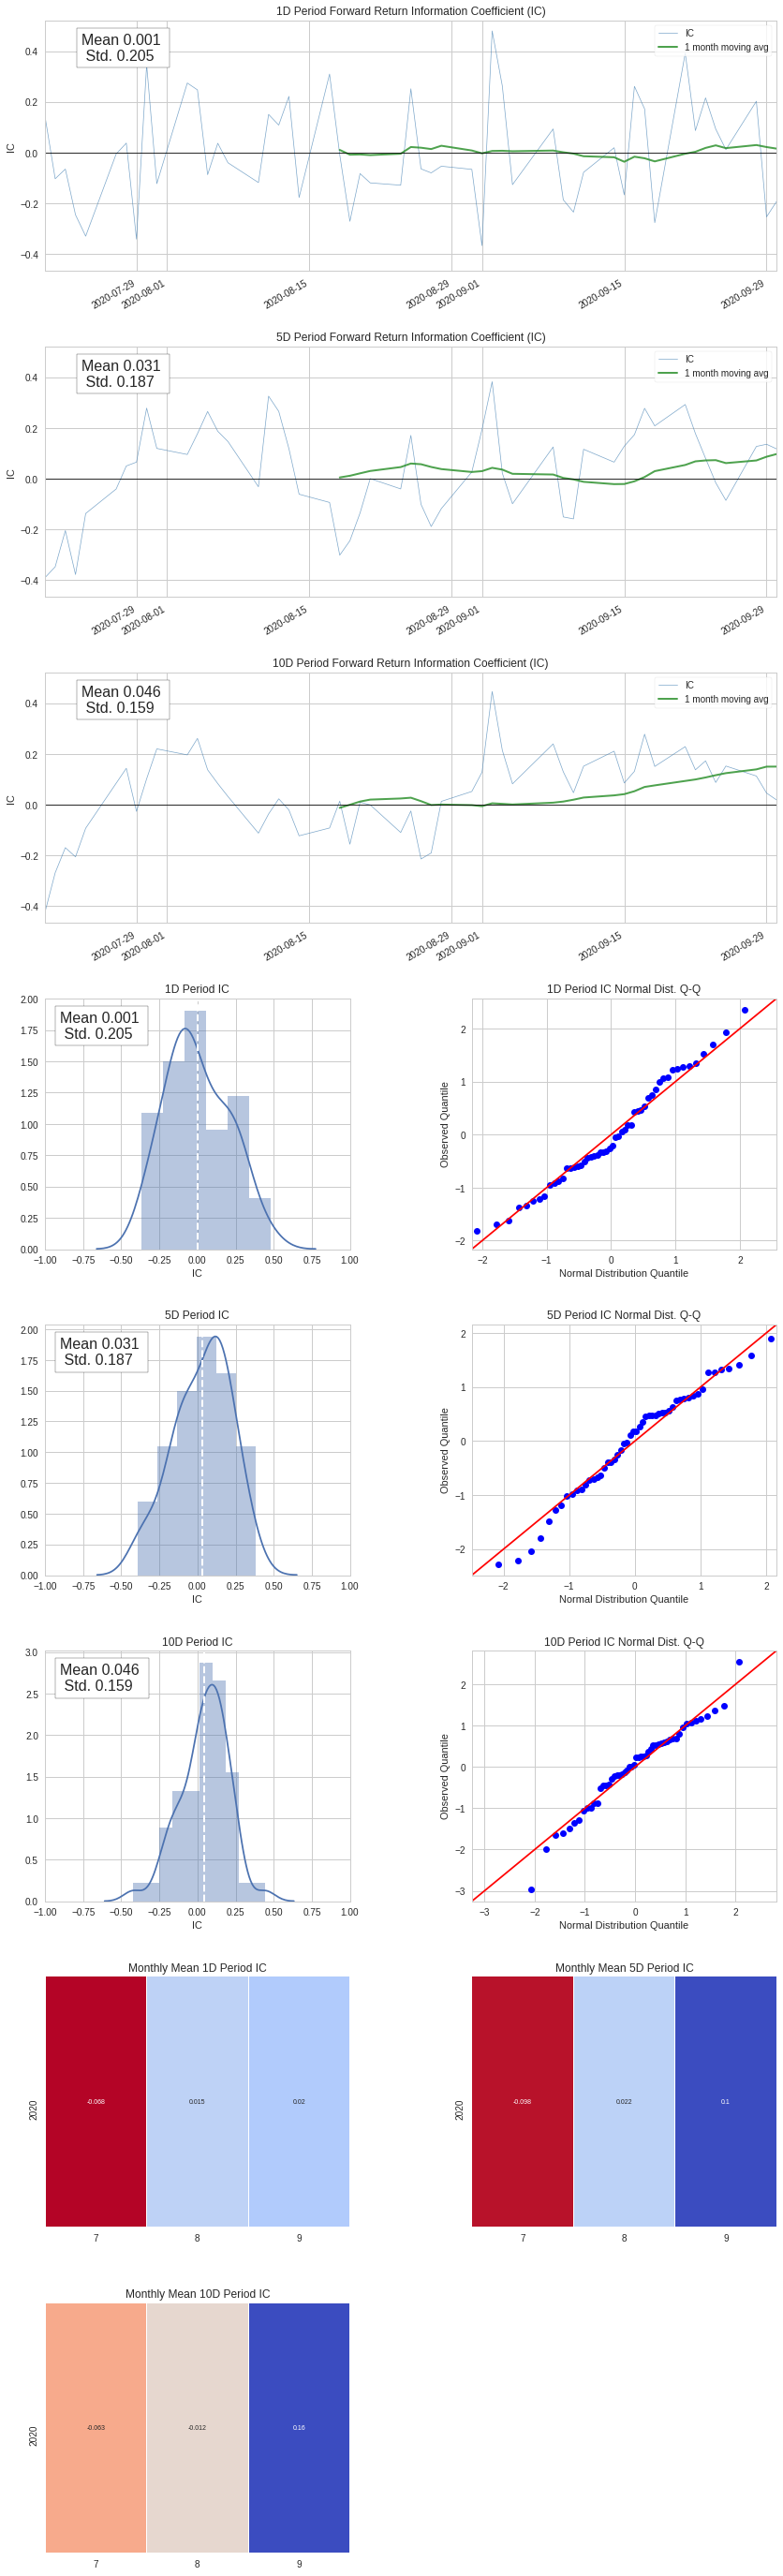

Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.334,0.738,0.926
Quantile 2 Mean Turnover,0.659,0.899,0.959
Quantile 3 Mean Turnover,0.878,0.962,0.971
Quantile 4 Mean Turnover,0.682,0.899,0.959
Quantile 5 Mean Turnover,0.382,0.760,0.935


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.916,0.834,0.724


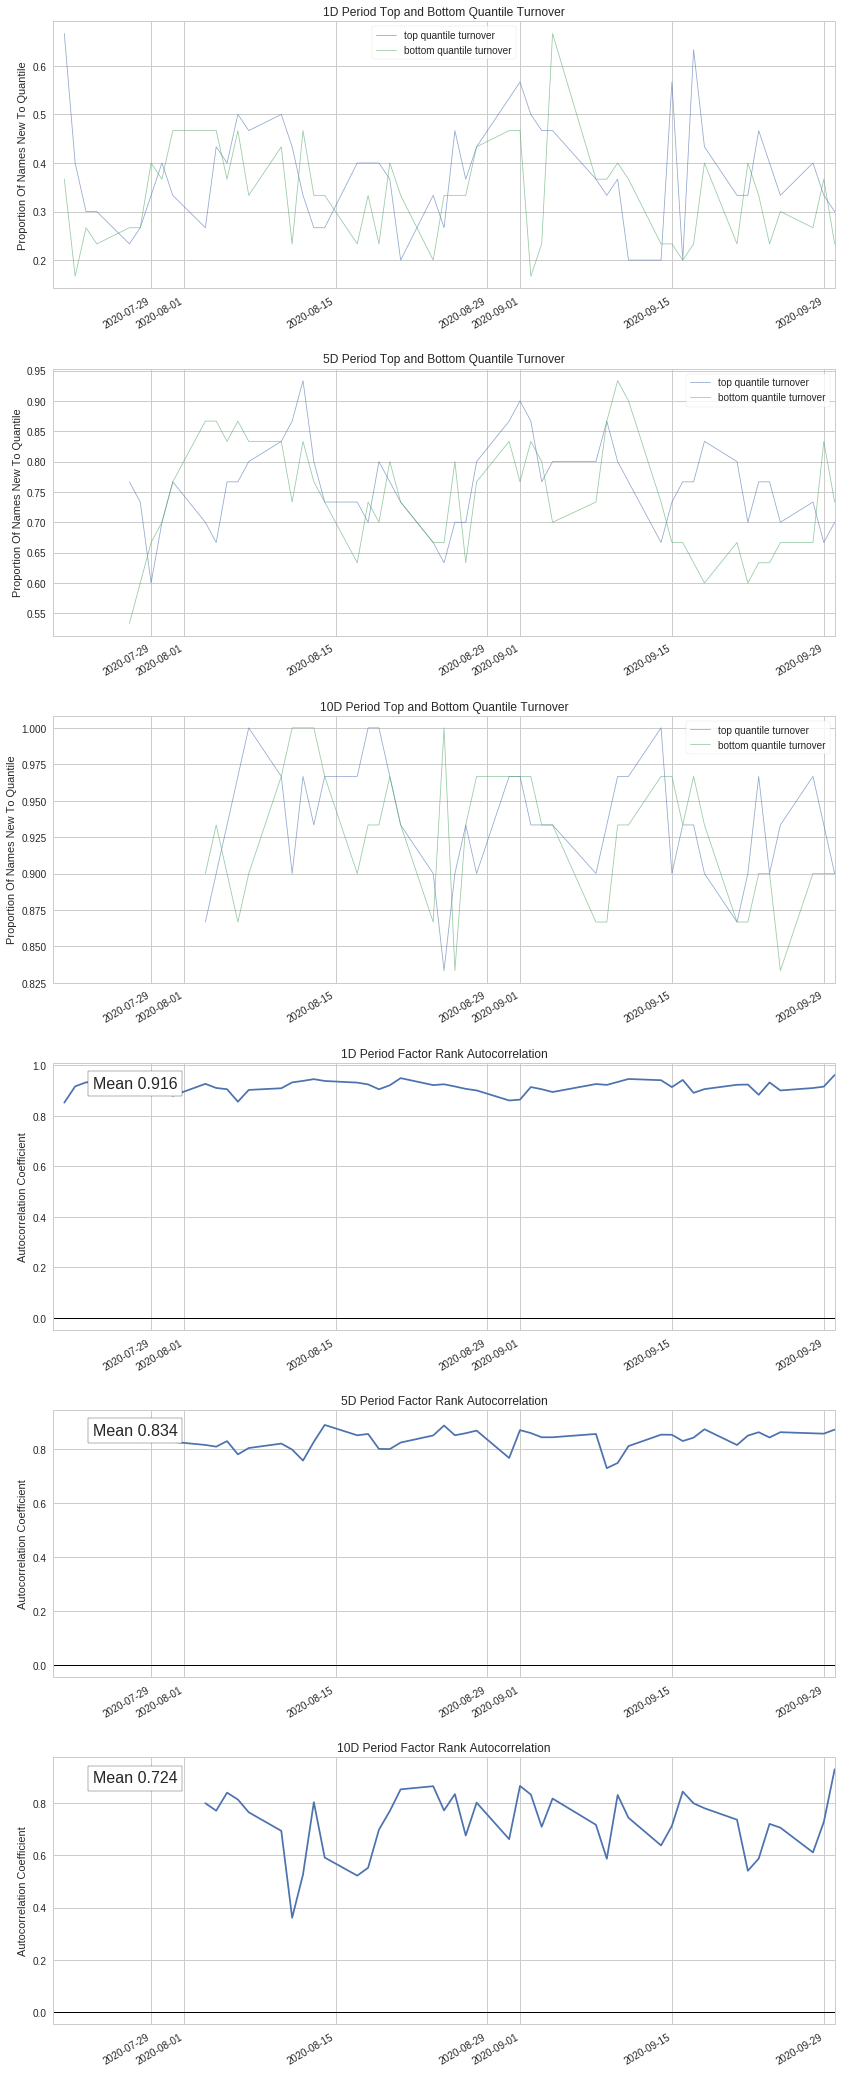

In [59]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(merged_data)

In [60]:
from alphalens.performance import factor_returns

factor_returns(merged_data)

,1D,5D,10D
date,,,
2020-07-20 00:00:00+00:00,0.004060,-0.019023,-0.037561
2020-07-21 00:00:00+00:00,-0.000459,-0.018257,-0.024411
2020-07-22 00:00:00+00:00,-0.002217,-0.014779,-0.021345
2020-07-23 00:00:00+00:00,-0.003949,-0.021196,-0.024818
2020-07-24 00:00:00+00:00,-0.009587,-0.008541,-0.011953
2020-07-27 00:00:00+00:00,0.000648,-0.004195,0.007584
2020-07-28 00:00:00+00:00,0.003821,-0.002031,0.012360
2020-07-29 00:00:00+00:00,-0.015083,-0.005982,-0.008919
2020-07-30 00:00:00+00:00,0.009342,0.014164,0.005425


Technical analysis can be considered as time series filters designed for financial data. A more general appaorch would be to use log-return for price data and normalised values for other data and apply different time series models such as ARIMA, GARCH model to analyse the data.

## Using fundamentals data

Quantopian supports the use of fundmanetal data from morningstar and Factset. There is a wide range of data avaliable on Quantopian and we select the most common ones as an example 

Dividend and earning yield

In [61]:
import datetime 
import pandas as pd
from quantopian.research import run_pipeline, symbols

from quantopian.pipeline import CustomFactor, Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.pipeline.data import EquityPricing

from quantopian.pipeline.factors import  Returns, FastStochasticOscillator, RSI, SimpleMovingAverage
from quantopian.pipeline.filters import  StaticAssets, QTradableStocksUS

In [62]:
# Get the latest daily close price for all equities.
yesterday_close = EquityPricing.close.latest

# Get the sum of dividend and buyback yield
earning_yield = Fundamentals.earning_yield.latest
dividend = Fundamentals.trailing_dividend_yield.latest

combined_factor = earning_yield.zscore() + dividend.zscore()

    
# Add the factor to the pipeline.
pipe = Pipeline({
                'close': yesterday_close,
                'earningyield': earning_yield ,
                'divd': dividend,
                'combined_factor': combined_factor,
        },
        domain = US_EQUITIES,
        screen =  ( QTradableStocksUS() 
                   & dividend.notnull()
                    ),
        )


enddate = datetime.datetime.now() + datetime.timedelta(days=-5)
startdate = datetime.datetime.now() + datetime.timedelta(days=-250)

factor_data = run_pipeline(pipe, startdate, enddate)


In [63]:
pricing_data = get_pricing(
  symbols= factor_data.index.levels[1], # Finds all assets that appear at least once in "factor_data"  
  start_date= startdate,
  end_date= enddate + pd.Timedelta(days=90), # must be after run_pipeline()'s end date. Explained more in lesson 4
  fields='open_price' # Generally, you should use open pricing. Explained more in lesson 4
)

from alphalens.utils import get_clean_factor_and_forward_returns

merged_data = get_clean_factor_and_forward_returns(
  factor=factor_data['combined_factor'], 
  prices=pricing_data
)


Dropped 4.9% entries from factor data: 4.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-73.507909,-0.137689,-0.247844,0.698706,43966,20.028517
2,-0.313062,-0.093458,-0.188439,0.042204,43876,19.987518
3,-0.261137,-0.030088,-0.135328,0.042015,43863,19.981596
4,-0.199384,0.070533,-0.059677,0.045325,43876,19.987518
5,-0.068510,9.138856,0.235840,0.387434,43936,20.014851


Returns Analysis


,1D,5D,10D
Ann. alpha,0.314,0.117,0.011
beta,0.314,0.339,0.239
Mean Period Wise Return Top Quantile (bps),-0.725,-0.066,-3.113
Mean Period Wise Return Bottom Quantile (bps),2.677,2.405,3.163
Mean Period Wise Spread (bps),-3.401,-3.097,-6.662


<Figure size 1008x576 with 0 Axes>

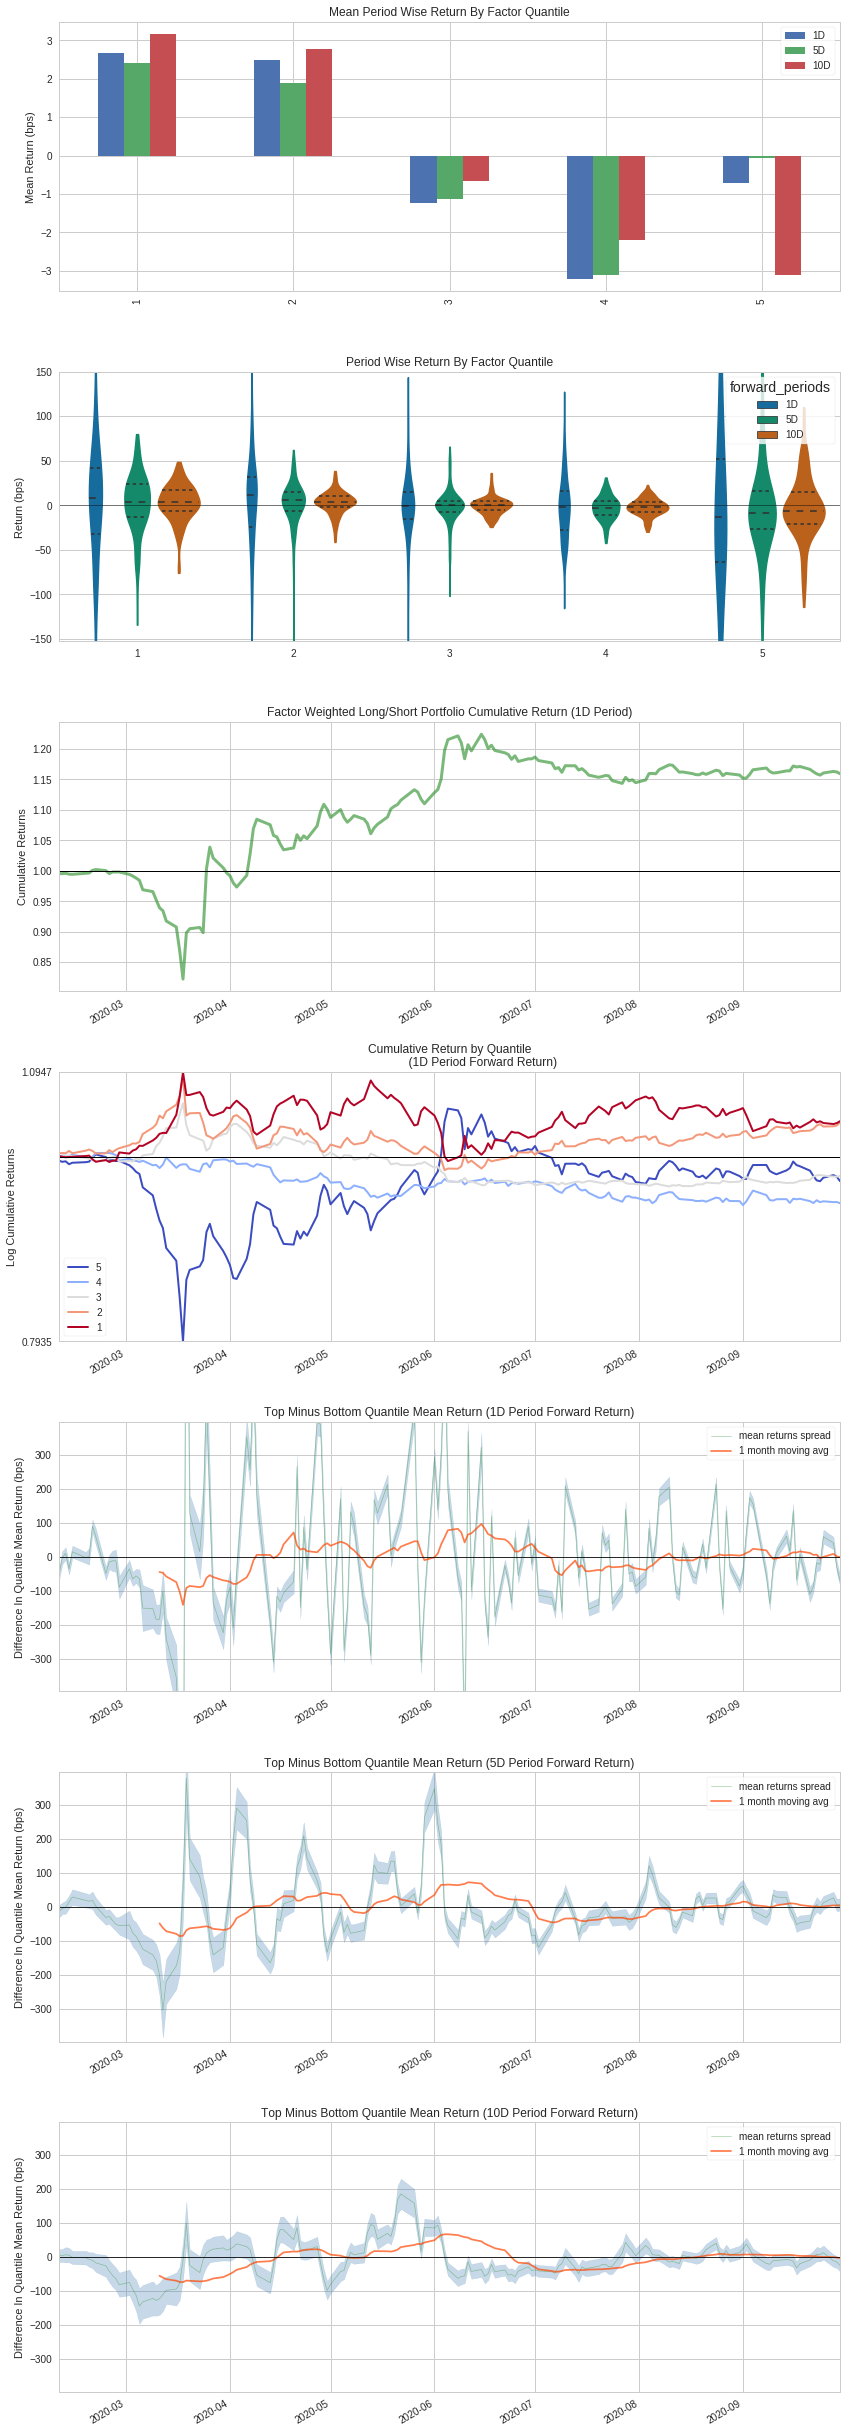

Information Analysis


,1D,5D,10D
IC Mean,-0.019,-0.030,-0.036
IC Std.,0.177,0.186,0.177
Risk-Adjusted IC,-0.105,-0.160,-0.200
t-stat(IC),-1.344,-2.039,-2.558
p-value(IC),0.181,0.043,0.011
IC Skew,0.387,0.431,0.544
IC Kurtosis,-0.679,-0.515,-0.242


In [ ]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(merged_data)

Value ratios 

In [ ]:
# Get the latest daily close price for all equities.
yesterday_close = EquityPricing.close.latest

# Get the sum of dividend and buyback yield
PB = Fundamentals.pb_ratio.latest
PCF = Fundamentals.pcf_ratio.latest
PE = Fundamentals.pe_ratio.latest

combined_factor = PB.zscore() + PCF.zscore() + PE.zscore()

    
# Add the factor to the pipeline.
pipe = Pipeline({
                'close': yesterday_close,
                'price_book': PB ,
                'price_cashflow': PCF,
                'price_earnings': PE,
                'combined_factor': combined_factor,
        },
        domain = US_EQUITIES,
        screen =  ( QTradableStocksUS() 
                   & PCF.notnull()
                    ),
        )


enddate = datetime.datetime.now() + datetime.timedelta(days=-5)
startdate = datetime.datetime.now() + datetime.timedelta(days=-250)

factor_data = run_pipeline(pipe, startdate, enddate)

In [ ]:
pricing_data = get_pricing(
  symbols= factor_data.index.levels[1], # Finds all assets that appear at least once in "factor_data"  
  start_date= startdate,
  end_date= enddate + pd.Timedelta(days=90), # must be after run_pipeline()'s end date. Explained more in lesson 4
  fields='open_price' # Generally, you should use open pricing. Explained more in lesson 4
)

from alphalens.utils import get_clean_factor_and_forward_returns

merged_data = get_clean_factor_and_forward_returns(
  factor=factor_data['combined_factor'], 
  prices=pricing_data
)


In [ ]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(merged_data)

Morningstar metrics 

In [ ]:
    # Get the latest daily close price for all equities.
    yesterday_close = EquityPricing.close.latest


    combined_factor = Fundamentals.growth_score.latest.zscore() + Fundamentals.value_score.latest.zscore() + \
    Fundamentals.style_score.latest.zscore()

    # Add the factor to the pipeline.
    pipe = Pipeline({
                    'close': yesterday_close,
                    'value': Fundamentals.value_score.latest ,
                    'style': Fundamentals.style_score.latest,
                    'growth': Fundamentals.growth_score.latest,
                    'combined_factor': combined_factor,
            },
            domain = US_EQUITIES,
            screen =  ( QTradableStocksUS() 
                       & Fundamentals.growth_score.latest.notnull()
                        ),
            )


enddate = datetime.datetime.now() + datetime.timedelta(days=-5)
startdate = datetime.datetime.now() + datetime.timedelta(days=-250)

factor_data = run_pipeline(pipe, startdate, enddate)

In [ ]:
pricing_data = get_pricing(
  symbols= factor_data.index.levels[1], # Finds all assets that appear at least once in "factor_data"  
  start_date= startdate,
  end_date= enddate + pd.Timedelta(days=90), # must be after run_pipeline()'s end date. Explained more in lesson 4
  fields='open_price' # Generally, you should use open pricing. Explained more in lesson 4
)

from alphalens.utils import get_clean_factor_and_forward_returns

merged_data = get_clean_factor_and_forward_returns(
  factor=factor_data['combined_factor'], 
  prices=pricing_data
)


In [ ]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(merged_data)

Question: How would you build factors using fundamentals data? A traditional approach would be using metrics commonly used in equity research such as PE ratio etc. A data driven approach would be to extract signals from the financial statemetnts directly. That requires a good way to normalise data and reduce the dimension of data.

Homework: 

Build a strategy that combines technical analysis and fundamentals factors. How would you combine different factors considering data can be of different scale and some data are categorical rather than continuous. 

Algo implementing a TA factor combining RSI and MFI

In [ ]:
from quantopian.pipeline import CustomFactor, Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals
from quantopian.pipeline.domain import US_EQUITIES

from quantopian.pipeline.data import EquityPricing

from quantopian.pipeline.factors import  Returns, FastStochasticOscillator, RSI, SimpleMovingAverage
from quantopian.pipeline.filters import  StaticAssets, QTradableStocksUS


import quantopian.optimize as opt
from quantopian.algorithm import order_optimal_portfolio
from quantopian.algorithm import attach_pipeline, pipeline_output
from quantopian.pipeline import Pipeline

class MoneyFlowIndex(CustomFactor):
    """
    Money Flow Index 
    """
    inputs = [EquityPricing.high, EquityPricing.low, EquityPricing.close, EquityPricing.volume]
    window_length = 15

    def compute(self, today, assets, out, highs, lows, closes, volume):
        import numpy as np
        
        typical_price = (highs+lows+closes)/3
        typical_price_diff = np.diff(typical_price,axis=0)
        money_flow = closes[1:,]*volume[1:,]
        positive_money_ratio = np.sum(np.where(typical_price_diff>0,money_flow,0),axis=0)
        negative_money_ratio = np.sum(np.where(typical_price_diff<0,money_flow,0),axis=0)
        MFR = positive_money_ratio/negative_money_ratio
        out[:] = 100 - 100/(1+MFR)
        




def initialize(context):
    # Schedule our rebalance function to run at the start of
    # each week, when the market opens.
    schedule_function(
        my_rebalance,
        date_rules.week_start(),
        time_rules.market_open()
    )

    # Create our pipeline and attach it to our algorithm.
    my_pipe = make_pipeline()
    attach_pipeline(my_pipe, 'my_pipeline')

def make_pipeline():

    # Get the latest daily close price for all equities.
    yesterday_close = EquityPricing.close.latest

    # Combine technical indicators 
    RSI_normalised = RSI(window_length=15).zscore()
    MFI_normalised =  MoneyFlowIndex(window_length=15).zscore()
    combined_factor = (RSI_normalised + MFI_normalised)/2


    # Filter to select securities to short.
    shorts = combined_factor.top(75,mask=QTradableStocksUS())

    # Filter to select securities to long.
    longs = combined_factor.bottom(75,mask=QTradableStocksUS())

    # Filter for all securities that we want to trade.
    securities_to_trade = (shorts | longs)

    # Add the factor to the pipeline.
    pipe = Pipeline({
                    'close': yesterday_close,
                    'RSI': SimpleMovingAverage([RSI(window_length=15)],window_length=10),
                    'MFI': MoneyFlowIndex(),
                    'combined_factor': combined_factor,
                    'longs': longs,
                    'shorts': shorts,
            },
            domain = US_EQUITIES,
            screen =  (QTradableStocksUS() & securities_to_trade) ,
    )
    
    return pipe 

def compute_target_weights(context, data):
    """
    Compute ordering weights.
    """

    # Initialize empty target weights dictionary.
    # This will map securities to their target weight.
    weights = {}

    # If there are securities in our longs and shorts lists,
    # compute even target weights for each security.
    if context.longs and context.shorts:
        long_weight = 0.5 / len(context.longs)
        short_weight = -0.5 / len(context.shorts)
    else:
        return weights

    # Exit positions in our portfolio if they are not
    # in our longs or shorts lists.
    for security in context.portfolio.positions:
        if security not in context.longs and security not in context.shorts and data.can_trade(security):
            weights[security] = 0

    for security in context.longs:
        weights[security] = long_weight

    for security in context.shorts:
        weights[security] = short_weight

    return weights

def before_trading_start(context, data):
    """
    Get pipeline results.
    """

    # Gets our pipeline output every day.
    pipe_results = pipeline_output('my_pipeline')

    # Go long in securities for which the 'longs' value is True,
    # and check if they can be traded.
    context.longs = []
    for sec in pipe_results[pipe_results['longs']].index.tolist():
        if data.can_trade(sec):
            context.longs.append(sec)

    # Go short in securities for which the 'shorts' value is True,
    # and check if they can be traded.
    context.shorts = []
    for sec in pipe_results[pipe_results['shorts']].index.tolist():
        if data.can_trade(sec):
            context.shorts.append(sec)

def my_rebalance(context, data):
    """
    Rebalance weekly.
    """

    # Calculate target weights to rebalance
    target_weights = compute_target_weights(context, data)

    # If we have target weights, rebalance our portfolio
    if target_weights:
        order_optimal_portfolio(
            objective=opt.TargetWeights(target_weights),
            constraints=[],
        )

Algo using moringstar fundamentals

In [ ]:
from quantopian.pipeline import CustomFactor, Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals
from quantopian.pipeline.domain import US_EQUITIES

from quantopian.pipeline.data import EquityPricing

from quantopian.pipeline.factors import  Returns, FastStochasticOscillator, RSI, SimpleMovingAverage
from quantopian.pipeline.filters import  StaticAssets, QTradableStocksUS


import quantopian.algorithm as algo
import quantopian.optimize as opt
from quantopian.algorithm import order_optimal_portfolio
from quantopian.algorithm import attach_pipeline, pipeline_output
from quantopian.pipeline import Pipeline

# Constraint Parameters
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600


MAX_SHORT_POSITION_SIZE = 2.0 / TOTAL_POSITIONS
MAX_LONG_POSITION_SIZE = 2.0 / TOTAL_POSITIONS


def initialize(context):
    
    algo.attach_pipeline(make_pipeline(), 'long_short_equity_template')

    algo.schedule_function(func=rebalance,
                           date_rule=algo.date_rules.week_start(),              time_rule=algo.time_rules.market_open(hours=0, minutes=30),
                           half_days=True)

def make_pipeline():

    yesterday_close = EquityPricing.close.latest

    combined_factor = Fundamentals.growth_score.latest.zscore() +     Fundamentals.value_score.latest.zscore() + \
    Fundamentals.style_score.latest.zscore()
    

    universe = QTradableStocksUS()
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)
    long_short_screen = (longs | shorts)

    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe


def before_trading_start(context, data):

    context.pipeline_data = algo.pipeline_output('long_short_equity_template')
    

def rebalance(context, data):

    # Retrieve pipeline output
    pipeline_data = context.pipeline_data

    objective = opt.MaximizeAlpha(pipeline_data.combined_factor)

    # Define the list of constraints
    constraints = []
    constraints.append(opt.MaxGrossExposure(MAX_GROSS_LEVERAGE))
    constraints.append(opt.DollarNeutral())
    
    constraints.append(
        opt.PositionConcentration.with_equal_bounds(
            min=-MAX_SHORT_POSITION_SIZE,
            max=MAX_LONG_POSITION_SIZE
        ))

    algo.order_optimal_portfolio(
        objective=objective,
        constraints=constraints
    )